In [163]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from urllib.request import urlopen
import QuantLib as ql

plt.rcParams["figure.figsize"] = (16,9)

**Forward Price(F)**
* mostly traded over the counter

In [164]:
def get_currency_fwd(spot_rate_domestic_forien,domestic_rate_pct,forien_rate_pct,t_years,is_cont=False):
    
    '''
    rate is in perecent
    Replication (Domestic: Yen , Forien: USD)
    1. Borrow Forien: USD 
    2. Sell Forien: USD for Domestic: Yen
    3. Invest the in Domestic: Yen rate
    '''
    # continous case
    if is_cont: return spot_rate_domestic_forien*np.exp((domestic_rate_pct-forien_rate_pct)*t_years/100)

    return spot_rate_domestic_forien*(1+domestic_rate_pct/100)**t_years/(1+forien_rate_pct/100)

def get_fwd_price(spot_price,rf_rate_pct,t_years,is_cont=False):
    
    '''
    rate is in perecent
    Replication 
    1. Borrow USD
    2. Invest the in USD
    '''
    # continous case
    if is_cont: return spot_price*np.exp(rf_rate_pct*t_years/100)

    return spot_price*(1+rf_rate_pct/100)**t_years

In [165]:
get_currency_fwd(120,0.15,2.40,1,True)

117.33014846320036

In [166]:
get_fwd_price(120,1.5,3,True)

125.52334318904603

**Futures Contracts(f)** 

Future(f) = Forward(F) will hold unless


* the riskless rate from now till T is unpredictable
* the spot price S is highly correlate with the rate

In [167]:
def get_future_price(spot_price,rf_rate_pct,t_years,is_cont=False): 
    return get_fwd_price(spot_price,rf_rate_pct,t_years,is_cont)

**Fixed Income Security**

In [168]:
def get_bond_price(coupon_rate, rf_rate, n, face_value):
    return (coupon_rate / rf_rate) * (1 - (1 + rf_rate)**-n) + face_value / (1 + rf_rate)**n

In [169]:
coupon_rate = 5
rf_rate = 0.05
n = 10
face_value = 100
get_bond_price(coupon_rate, rf_rate, n, face_value)

100.0

In [170]:
import QuantLib as ql

today = ql.Date.todaysDate()
calendar = ql.TARGET()
day_counter = ql.ActualActual(ql.ActualActual.ISMA)
issue_date = ql.Date(1, 1, 2021)
maturity_date = ql.Date(1, 1, 2031)
coupon_rate = 0.05
face_value = 100

bond_schedule = ql.Schedule(issue_date, maturity_date, ql.Period(ql.Semiannual), calendar, ql.Unadjusted, ql.Unadjusted, ql.DateGeneration.Backward, False)
bond = ql.FixedRateBond(0, face_value, bond_schedule, [coupon_rate], day_counter)

yield_rate = 0.03
discount_curve = ql.FlatForward(today, ql.QuoteHandle(ql.SimpleQuote(yield_rate)), day_counter)
bond.setPricingEngine(ql.DiscountingBondEngine(ql.YieldTermStructureHandle(discount_curve)))

price = bond.dirtyPrice()
print('Bond price:', price)


Bond price: 114.52998153998897


**Swap**
* assume market are perfect


In [171]:
def get_fair_swap_fixed_price(discount_rates,fwd_com_prices): # maturity_years unit: years
    discount_rates = np.array(discount_rates)
    fwd_com_prices = np.array(fwd_com_prices)
    return (discount_rates@fwd_com_prices.T)/np.sum(discount_rates)

discount_rates = [0.970,0.941,0.912,0.883]
fwd_com_prices = [1435,1485,1540,1565] # fwd gold price

price = get_fair_swap_fixed_price(discount_rates, fwd_com_prices)
print("Fair fixed swap price:", price) 

Fair fixed swap price: 1504.508904479223


In [172]:
def get_fair_int_swap_rate(rates,discount_rates):
    """
    Replicate (floating rate using t bill and fixed rate(swap rate))
    1. borrow 1-B0 cash and short bond B0 and invest 1 in tbill at t0
    2. get 1+R12 from t bill, pay 1 back from borrowing cost at t2
    ...
    5. get 1+R45 from t bill, pay 1 back from borrowing cost at t5 
    """
    return (discount_rates@rates.T)/np.sum(discount_rates) # similar to vanilla swap


**EL: Swaps (Monte-Carlo)**

This will calculate the CVA on a swap with a fixed rate of 5%, a notional amount of $100, a maturity of 1 year, a recovery rate of 40%, a default probability of 10%, and a spread of 1%. The simulation will generate 10,000 scenarios to estimate the expected loss.

In [173]:
def cva_swap(fixed_rate, notional, maturity, recovery_rate, default_prob, spread, num_simulations):
    dt = maturity / num_simulations
    e = np.random.normal(0, 1, num_simulations)
    r = fixed_rate + spread
    pv = np.zeros(num_simulations)
    for i in range(num_simulations):
        if e[i] < default_prob:
            pv[i] = notional * recovery_rate / (1 + r * dt)**(num_simulations - i)
        else:
            pv[i] = notional * fixed_rate * dt / (1 + r * dt)**(num_simulations - i)
    return np.mean(pv)

fixed_rate = 0.05
notional = 100
maturity = 1
recovery_rate = 0.4
default_prob = 0.1
spread = 0.01
num_simulations = 10000

cva = cva_swap(fixed_rate, notional, maturity, recovery_rate, default_prob, spread, num_simulations)
print("CVA:", cva)


CVA: 21.049115903790756


**Options(Model-Free)**
* Option never have a negative value
* An american is at least as valuable as corresponding European C(American) > c and P(American) > c
* Call option is never worth more than the stock and a put is never worth more than the exercise price

**Call Pay off**

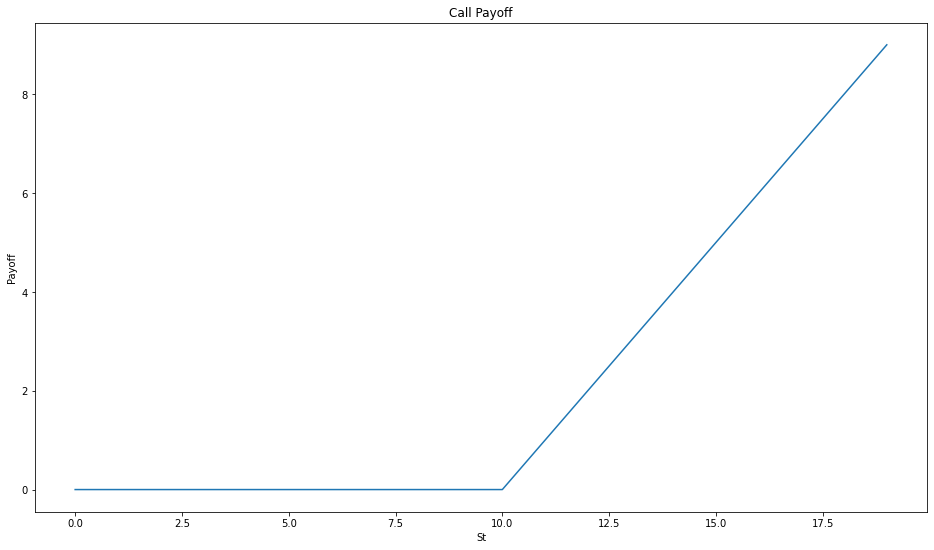

In [174]:
K = 10
S = np.arange(0,20)
c = [max(0, St - K) for St in S]
plt.xlabel("St")
plt.ylabel("Payoff")
plt.title("Call Payoff")
plt.plot(S,c)

**Put Payoff**

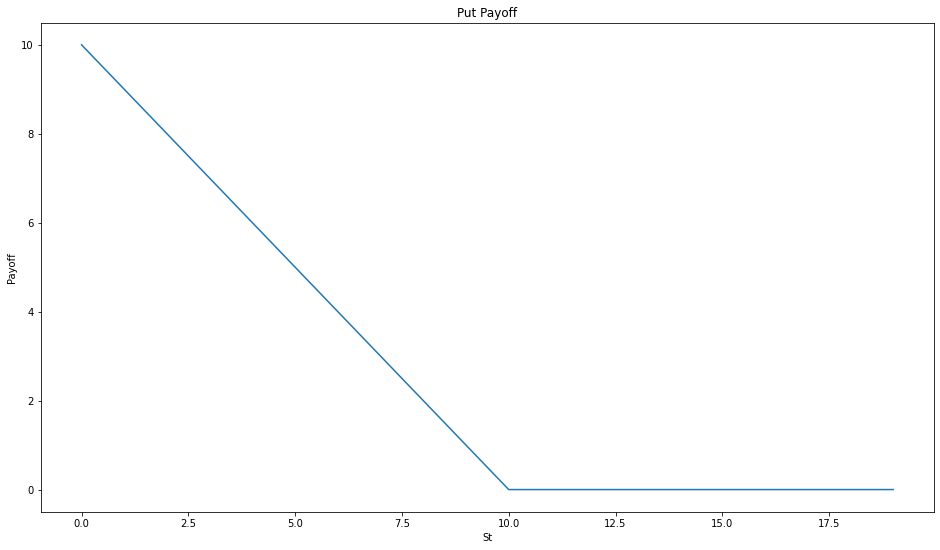

In [175]:
K = 10
S = np.arange(0,20)
p = [max(0, K - St) for St in S]
plt.xlabel("St")
plt.ylabel("Payoff")
plt.title("Put Payoff")
plt.plot(S,p)

** Arbitarge Opportunities** 
if c < S-K*B we have an arbitarge: (call are cheap)

**At t = 0**
* buy call :-c 
* Sell short : stock +St
* buy(payoffK) Treasuray bill : -K*B ; B = discount rate


**Combine:** *St-K x B - c* 


**At t = T**
* call payoff : max(0,ST-K)
* Short payoff : -St
* Treasuary bill payoff: K

**Combine:** *max(0,ST-K) - (ST - K)* always positive payoff

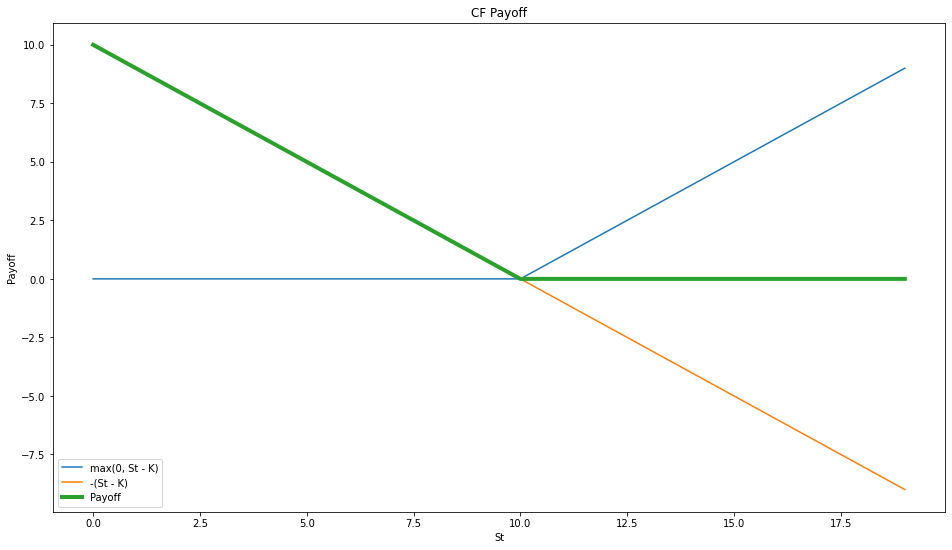

In [176]:
K = 10
B = 0.9
S = np.arange(0,20)
max_st_k = np.array([max(0, St - K) for St in S])
minus_St_K = np.array([-(St - K) for St in S])
plt.xlabel("St")
plt.ylabel("Payoff")
plt.title("CF Payoff")
plt.plot(S,max_st_k, label = "max(0, St - K)")
plt.plot(S,minus_St_K, label = "-(St - K)")
plt.plot(S,max_st_k+minus_St_K,linewidth = 4, label = "Payoff")
plt.legend()
plt.show()

**European Call on non-dividend-paying stocks**
* max(0,St-KB): lower bound(max(St-K*B)) <= c(S,K,t,T) <= St 

Then call price must lie in this between St and max(St-K*B) : shaded region

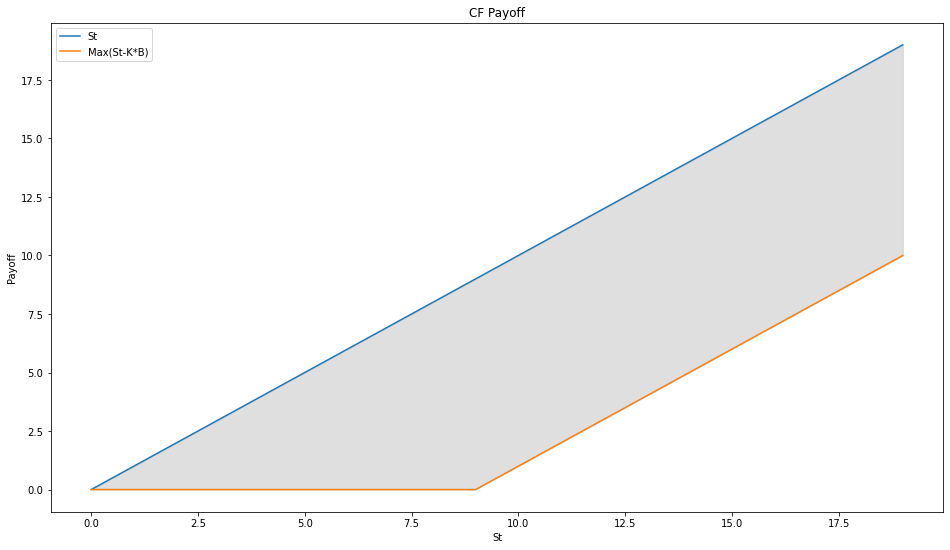

In [177]:
K = 10
B = 0.9
S = np.arange(0,20)
c = [max(0, St - K*B) for St in S]

plt.xlabel("St")
plt.ylabel("Payoff")
plt.title("CF Payoff")
plt.plot(S,S, label = "St")
plt.plot(S,c, label = "Max(St-K*B)")
plt.fill_between(S, S, c, where=(S > c), interpolate=True, color='gray', alpha=0.25)
plt.legend()
plt.show()


**European Put on Non-dividend-paying stocks**

Max(0,K*Bt-St) <= p(S,K,t,T) <= K*Bt

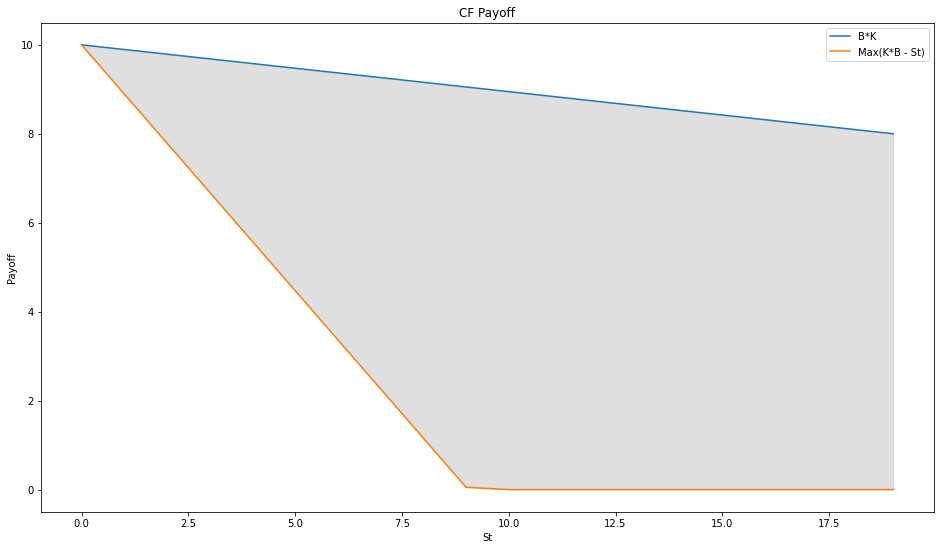

In [178]:
K = 10
B = np.linspace(1,0.8,20) # discont function
S = np.arange(0,20)
p = [max(0, K*B[i] - S[i]) for i in range(20)]
tmp = B*K
plt.xlabel("St")
plt.ylabel("Payoff")
plt.title("CF Payoff")
plt.plot(S,tmp, label = "B*K")
plt.plot(S,p, label = "Max(K*B - St)")
plt.fill_between(S, tmp, p, where=(tmp > p), interpolate=True, color='gray', alpha=0.25)
plt.legend()
plt.show()


**Put-Call Parity(no payouts)**

**European Case** 

St = c(S,K,t,T) - p(S,K,t,T) + K*B(t,T)


***Proof*** (we can see that c(T)-p(T)+K is the same as stock price)

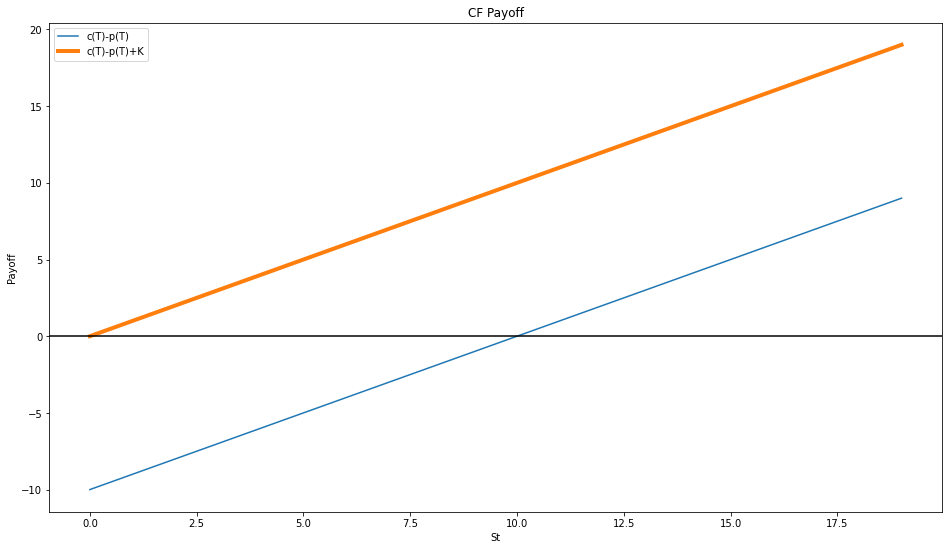

In [179]:
K = 10
S = np.arange(0,20)
p = np.array([max(0, K - St) for St in S])
c = np.array([max(0, St - K) for St in S])
plt.xlabel("St")
plt.ylabel("Payoff")
plt.title("CF Payoff")
plt.plot(S,c-p, label = "c(T)-p(T)")
plt.plot(S,c-p + K,lw = 4, label = "c(T)-p(T)+K")
plt.axhline(0, color='black')
# plt.plot(S,p, label = "Max(K*B - St)")
plt.legend()
plt.show()


**Synthethic stock:** S = c - p + PV(K)

**Synthethic call:** c = S + p - PV(K)

**Synthethic put:** p = c - S + PV(K)

**Synthethic bond:** PV(K) = S - c + p

**American Case**
P>=p and C=c on non dividend paying stock

    P >= C + B * K - S
*Non arbiarge*
    
    c + K >= P + S

**Bear Put Spreads**
* Cost today p(K2)-p(K1)

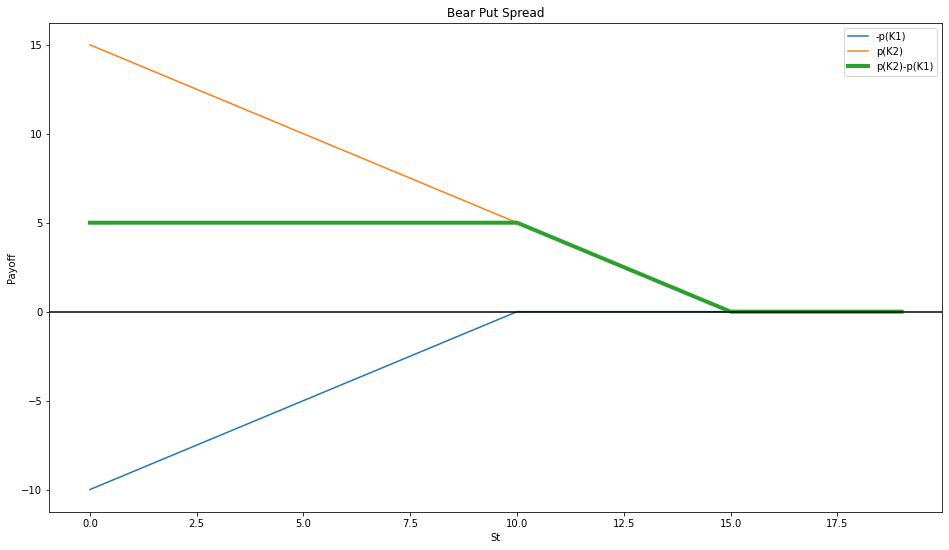

In [180]:
K1 = 10
K2 = 15
S = np.arange(0,20)
p1 = np.array([max(0, K1 - St) for St in S])
p2 = np.array([max(0, K2 - St) for St in S])
plt.xlabel("St")
plt.ylabel("Payoff")
plt.title("Bear Put Spread")
plt.plot(S,-p1, label = "-p(K1)")
plt.plot(S,p2, label = "p(K2)")
plt.plot(S,p2-p1,lw = 4, label = "p(K2)-p(K1)")
plt.axhline(0, color='black')
plt.legend()
plt.show()


**Bull Put Spread**
* p(K1) - p(K2) (<=0)

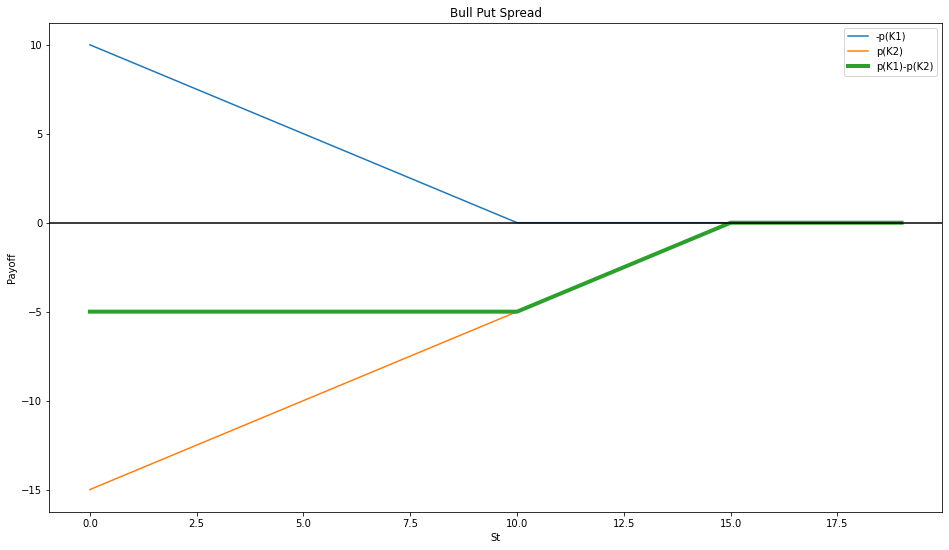

In [181]:
K1 = 10
K2 = 15
S = np.arange(0,20)
p1 = np.array([max(0, K1 - St) for St in S])
p2 = np.array([max(0, K2 - St) for St in S])
plt.xlabel("St")
plt.ylabel("Payoff")
plt.title("Bull Put Spread")
plt.plot(S,p1, label = "-p(K1)")
plt.plot(S,-p2, label = "p(K2)")
plt.plot(S,p1-p2,lw = 4, label = "p(K1)-p(K2)")
plt.axhline(0, color='black')
plt.legend()
plt.show()


**Bull Put Spread + Bond (with face value K2-K1)**


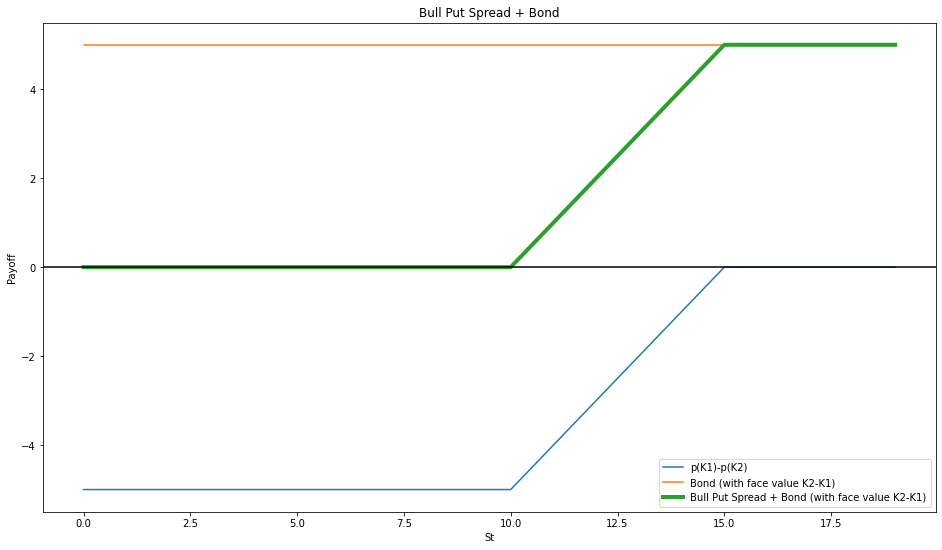

In [182]:
K1 = 10
K2 = 15
S = np.arange(0,20)
p1 = np.array([max(0, K1 - St) for St in S])
p2 = np.array([max(0, K2 - St) for St in S])
b = np.array([K2-K1]*20)
plt.xlabel("St")
plt.ylabel("Payoff")
plt.title("Bull Put Spread + Bond")
plt.plot(S,p1-p2, label = "p(K1)-p(K2)")
plt.plot(S,b, label = "Bond (with face value K2-K1)")
plt.plot(S,b+(p1-p2), lw = 4,label = 'Bull Put Spread + Bond (with face value K2-K1)')
plt.axhline(0, color='black')
plt.legend()
plt.show()


**Bear Call Spread**
* c(K2) - c(K1) (<=0)

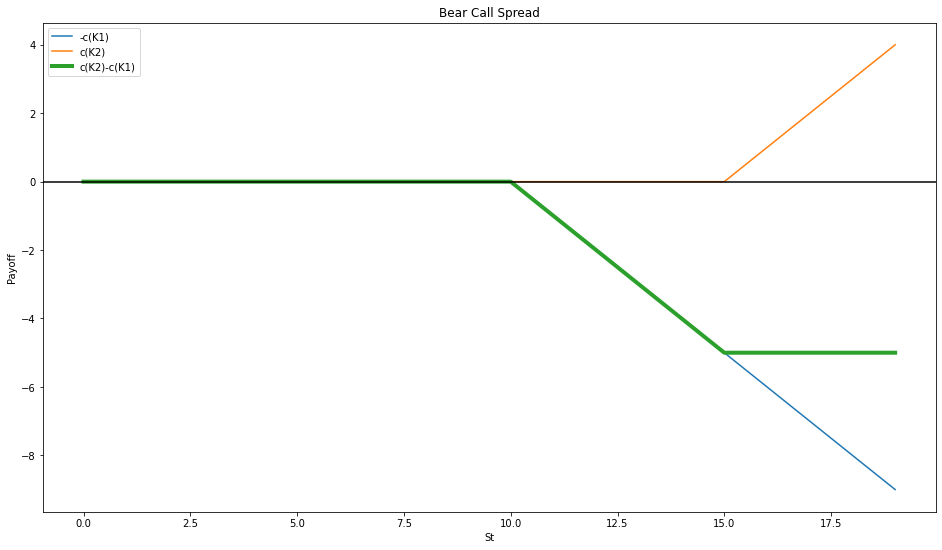

In [183]:
K1 = 10
K2 = 15
S = np.arange(0,20)
c1 = np.array([max(0, St - K1) for St in S])
c2 = np.array([max(0, St - K2) for St in S])
plt.xlabel("St")
plt.ylabel("Payoff")
plt.title("Bear Call Spread")
plt.plot(S,-c1, label = "-c(K1)")
plt.plot(S,c2, label = "c(K2)")
plt.plot(S,c2-c1,lw = 4, label = "c(K2)-c(K1)")
plt.axhline(0, color='black')
plt.legend()
plt.show()


**Bear Call Spread + Bond (with face value K2-K1)**

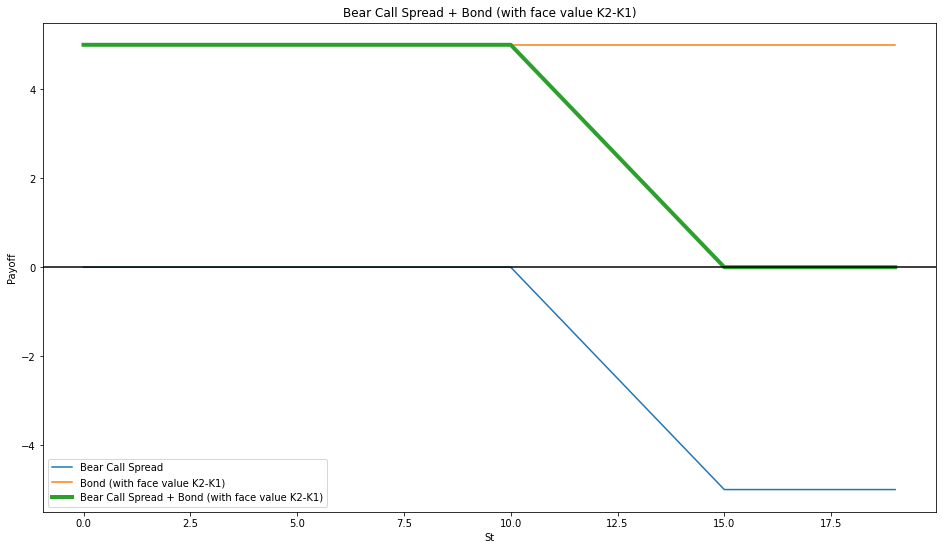

In [184]:
K1 = 10
K2 = 15
S = np.arange(0,20)
c1 = np.array([max(0, St - K1) for St in S])
c2 = np.array([max(0, St - K2) for St in S])
plt.xlabel("St")
plt.ylabel("Payoff")
plt.title("Bear Call Spread + Bond (with face value K2-K1)")
plt.plot(S,c2-c1, label = "Bear Call Spread")
plt.plot(S,b, label = "Bond (with face value K2-K1)")
plt.plot(S,b+(c2-c1), lw = 4,label = 'Bear Call Spread + Bond (with face value K2-K1)')
plt.axhline(0, color='black')
plt.legend()
plt.show()


**Butterfly Spreads (with Calls)**
* c(K1) - 2c(K2) + c(K3) (>=0)

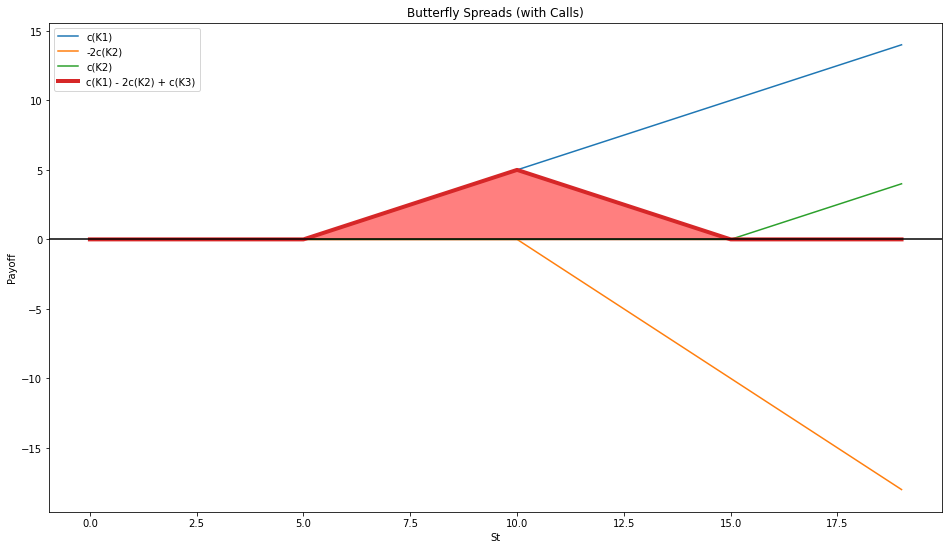

In [185]:
K1 = 5
K2 = 10
K3 = 15
S = np.arange(0,20)
c1 = np.array([max(0, St - K1) for St in S])
c2 = np.array([max(0, St - K2) for St in S])
c3 = np.array([max(0, St - K3) for St in S])
plt.xlabel("St")
plt.ylabel("Payoff")
plt.title("Butterfly Spreads (with Calls)")
plt.plot(S,c1, label = "c(K1)")
plt.plot(S,-2*c2, label = "-2c(K2)")
plt.plot(S,c3, label = "c(K2)")
plt.plot(S,c1-2*c2+c3,lw = 4, label = "c(K1) - 2c(K2) + c(K3)")
plt.fill_between(S, c1-2*c2+c3, 0, color='red', alpha=0.5)

plt.axhline(0, color='black')
plt.legend()
plt.show()


**Butterfly Spreads (with Puts)**
* p(K1) - 2p(K2) + p(K3) (>=0)

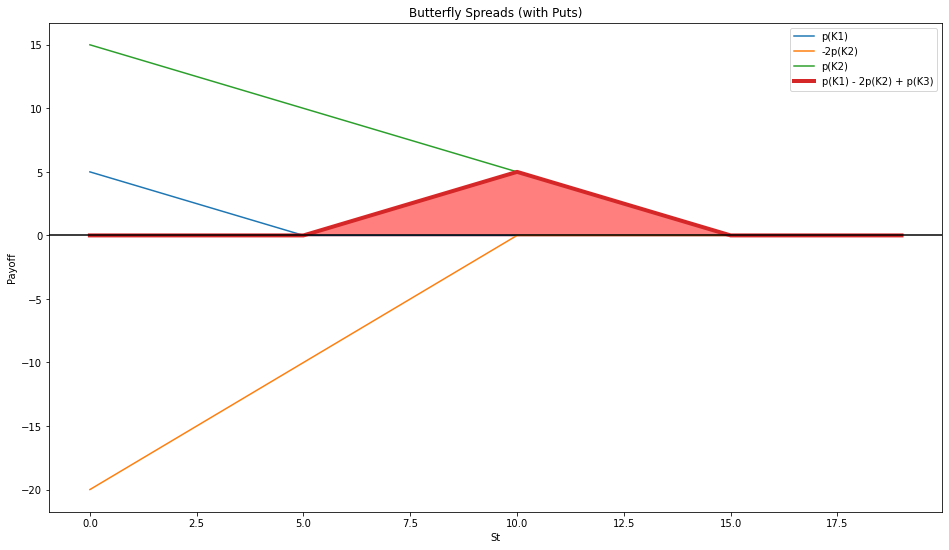

In [186]:
K1 = 5
K2 = 10
K3 = 15
S = np.arange(0,20)
p1 = np.array([max(0, K1 - St) for St in S])
p2 = np.array([max(0, K2 - St) for St in S])
p3 = np.array([max(0, K3 - St) for St in S])
plt.xlabel("St")
plt.ylabel("Payoff")
plt.title("Butterfly Spreads (with Puts)")
plt.plot(S,p1, label = "p(K1)")
plt.plot(S,-2*p2, label = "-2p(K2)")
plt.plot(S,p3, label = "p(K2)")
plt.plot(S,p1-2*p2+p3,lw = 4, label = "p(K1) - 2p(K2) + p(K3)")
plt.fill_between(S, p1-2*p2+p3, 0, color='red', alpha=0.5)

plt.axhline(0, color='black')
plt.legend()
plt.show()


**Convexity of Butterfly Spreads**
* [c(K3) - c(K2)] - [c(K2) - c(K1)] >= 0
* (c(K3) - c(K2))/(K3-K2) - (c(K2) - c(K1))/(K2-K1) >= 0
* (p(K3) - p(K2))/(K3-K2) - (p(K2) - p(K1))/(K2-K1) >= 0

**More of Butterfly Spreads**
* c(K1) - 2c(K2) + c(K3)
* 5 * (c(K1) - 2c(K2) + c(K3))

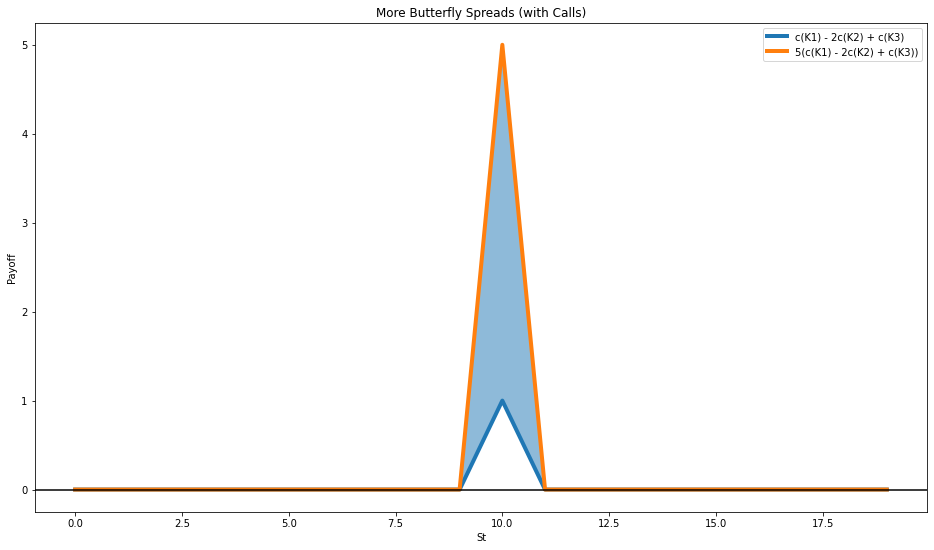

In [197]:
K1 = 9
K2 = 10
K3 = 11
S = np.arange(0,20)
c1 = np.array([max(0, St - K1) for St in S])
c2 = np.array([max(0, St - K2) for St in S])
c3 = np.array([max(0, St - K3) for St in S])
plt.xlabel("St")
plt.ylabel("Payoff")
plt.title("More Butterfly Spreads (with Calls)")
plt.plot(S,c1-2*c2+c3,lw = 4, label = "c(K1) - 2c(K2) + c(K3)")
plt.plot(S,5*(c1-2*c2+c3),lw = 4, label = "5(c(K1) - 2c(K2) + c(K3))")
plt.fill_between(S, 5*(c1-2*c2+c3), c1-2*c2+c3, alpha=0.5)

plt.axhline(0, color='black')
plt.legend()
plt.show()


if we buy all butterfly spread we wil get Zero Coupon Bond(ZCB) since each one of these will get pay off.
* B = Bond, b = butterfly price
* $1 = \frac{\sum_{k = 0}^{inf} b_{k,t,T_i}}{B} = \sum_{}q_k$

**So if we can price butterflies, we can price any derivative!**